# EOF Analysis of NEMO surface tracers

***

In [44]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools

%matplotlib inline

***

## Load data

Concatenated at the command line using NCO

In [38]:
# Load netCDF files
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

In [4]:
# Characterize subgrid
xrange, yrange, skip = [115, 361], [310, 789], 2
gridx, gridy = np.meshgrid(ptrc.x[::skip], ptrc.y[::skip])
shape = gridx.shape
npoints = np.prod(shape)

# Construct flattened variables
tmask = mask.tmask[0, 0, slice(*yrange), slice(*xrange)].values[::skip, ::skip].reshape(npoints).astype(bool)
gridx = gridx.reshape(npoints)[tmask]
gridy = gridy.reshape(npoints)[tmask]
nitrate = ptrc.nitrate[:, 0, ...].values[:, ::skip, ::skip].reshape(-1, npoints)[:, tmask]

***

## Filtering

Per Rich's recommendations, using a moving-average filter

In [5]:
def plot_filter(cutoff, units):
    """Examine filter properties
    """
    
    # Define parameters
    rate = {'h': 1, 'm': 1 / 500}
    n = len(nitrate[:, 0])
    freq = np.linspace(-rate[units]/2, rate[units]/2, n)
    W = (cutoff * rate[units] / 2 * np.array([0.765, 1.168, 1.468])).astype('int') * 2 + 1
    order = 10**(np.floor(np.log10(1 / cutoff)) - 1)

    # Make plots
    fig, axs = plt.subplots(1, 2, figsize=(17, 6))
    lims = [(-max(W)/2, max(W)/2, 0, 2.5/max(W)), (order, rate[units]/2, 1e-10, 2)]
    labels = [(f'Phase lag [{units}]', 'Weights'), (f'Frequency [cp{units}]', 'Attenuation PSD')]
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].plot([1/cutoff, 1/cutoff], lims[1][2:], 'k--')
    axs[1].plot(lims[1][:2], [0.1, 0.1], 'k--')
    axs[1].text(1/cutoff + order, 0.2, f'10-fold attenuation at {cutoff} {units}')
    for ax, lim, label in zip(axs, lims, labels):
        ax.set_xlim(lim[:2])
        ax.set_ylim(lim[2:])
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])

    # Plot filters
    for window_type, w in zip(['boxcar', 'hamming', 'blackman'], W):
        w2 = (w - 1) / 2
        window = signal.get_window(window_type, w)
        window = window / sum(window)
        PSD = abs(fftshift(fft(window, n)))**2
        axs[0].plot(np.linspace(-w2, w2, w), window, label=f'{window_type}: {np.round(w/rate[units]):.0f} {units}')
        axs[1].plot(freq, PSD)
        if window_type is 'boxcar':
            [axs[0].plot([fac*w2, fac*w2], [0, window[0]], 'k--') for fac in [-1, 1]]

    axs[0].legend()

***

### Temporal filtering

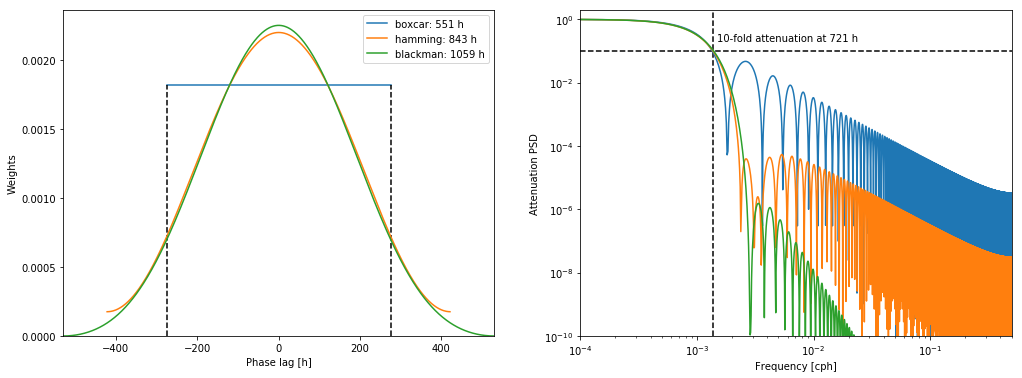

In [6]:
# Plot filter characteristics for 721 hour (30 day) cutoff
plot_filter(721, 'h')

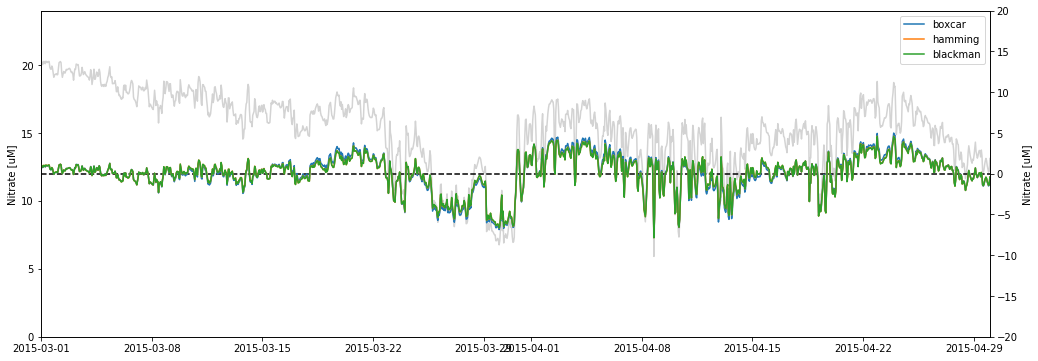

In [8]:
# ------ Subtract filters to construct bandpass ------

# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(ptrc.time_counter.values, nitrate[:, 0], '-', color='lightgray')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot(xlim, [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
nitrate_highpass = {}
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], [551, 841, 1057]):
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    nitrate_highpass[window_type] = np.empty(nitrate.shape)
    for i, loc in zip(tqdm(range(nitrate.shape[1])), nitrate.T):
        nitrate_highpass[window_type][:, i] = loc - signal.convolve(loc, window, mode='same')
    ax2.plot(ptrc.time_counter.values, nitrate_highpass[window_type][:, 0], label=window_type)
    
ax2.legend()
plt.show()

***

### Spatial filtering

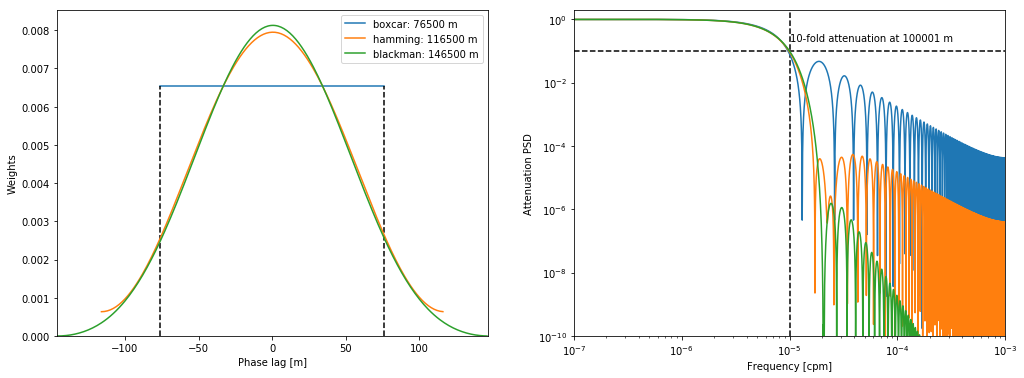

In [9]:
# Plot filter characteristics for 1e5 m (100 km) cutoff
plot_filter(100001, 'm')

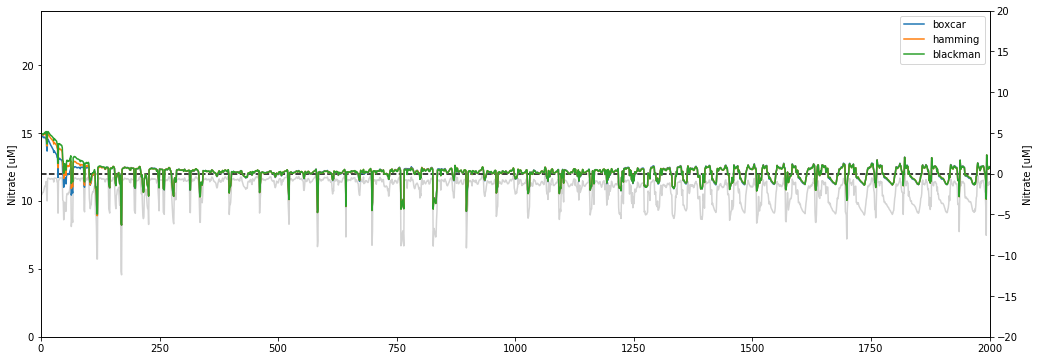

In [10]:
# ------ Subtract filters to construct bandpass ------

# Make figure
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(range(nitrate.shape[1]), nitrate_highpass['boxcar'][0, :], '-', color='lightgray')
ax.set_xlim([0, 2000])
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot([0, 2000], [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
nitrate_filtered = {}
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], [153, 233, 293]):
    window = signal.get_window('hamming', w)
    window = window / sum(window)
    nitrate_filtered[window_type] = np.empty(nitrate.shape)
    for i, t in zip(tqdm(range(nitrate.shape[0])), nitrate_highpass[window_type]):
        nitrate_filtered[window_type][i, :] = t - signal.convolve(t, window, mode='same')
    ax2.plot(range(nitrate.shape[1]), nitrate_filtered[window_type][0, :], label=window_type)
    
ax2.legend()
plt.show()

***

## Calculate EOF

In [11]:
A_prime, sqrtL, E_T = np.linalg.svd(nitrate_highpass['boxcar'], full_matrices=False)

In [29]:
gridded = np.zeros(ptrc.nav_lon.shape)
for y, x, val in zip(gridy, gridx, E_T.T[:, 0]):
    gridded[..., y, x] = val
gridded = gridded[..., ::skip, ::skip]

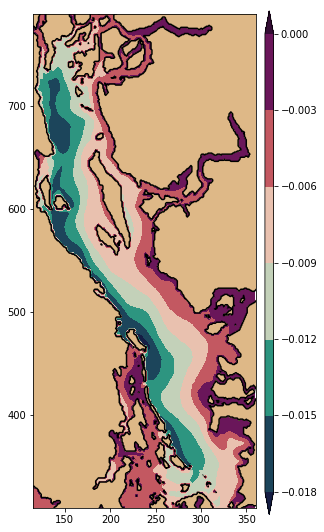

In [49]:
fig, ax = plt.subplots(figsize=(4, 10))
cax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
c = ax.contourf(mask.x[slice(*xrange, 2)], mask.y[slice(*yrange, 2)], gridded, cmap=cm.curl, extend='both')
ax.contourf(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
ax.contour(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
viz_tools.set_aspect(ax)
ax.set_xlim(xrange)
ax.set_ylim(yrange)
fig.colorbar(c, cax=cax)